In [25]:
import numpy as np
from scipy.optimize import minimize

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import tresonator as T

import skrf as rf
rf.stylely()

## S11 vs Frequency 

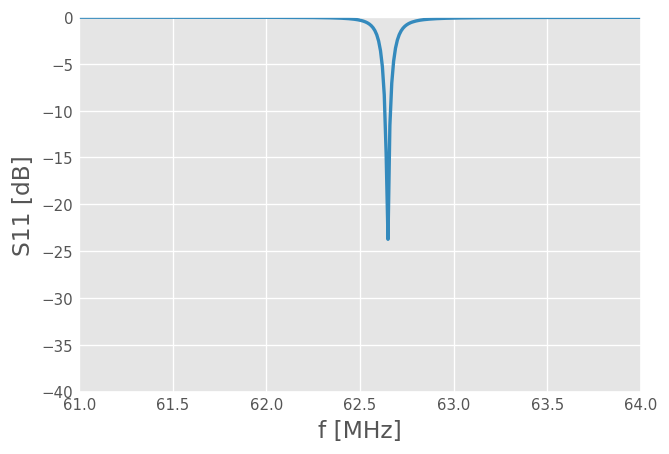

In [26]:
fs = 1e6*np.linspace(61, 64, 301)
P_in = 20e3 # W

@interact(Lsc_DUT=(20, 60, 0.1), Lsc_CEA=(1, 200, 0.1), 
          Z_DUT=(1, 1e2, 0.1), Z_CEA=(1, 1e2, 0.1), 
          add_loss=(0.1, 5, 0.1))
def S11_vf_f(Lsc_DUT=33, Lsc_CEA=32, 
             Z_DUT = 6, Z_CEA = 6,
             add_loss=1.0):
    S11dB = []
    for f in fs:
        _cfg = T.Configuration(f, P_in, Lsc_DUT*1e-3, Lsc_CEA*1e-3, 
                               Z_short_DUT = Z_DUT*1e-3, Z_short_CEA = Z_CEA*1e-3, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    fig,ax=plt.subplots()
    ax.plot(fs/1e6, S11dB, lw=2)
    ax.grid(True)
    ax.set_ylim(-40,0)
    ax.set_xlabel('f [MHz]', fontsize=14)
    ax.set_ylabel('S11 [dB]', fontsize=14)

## Map of the short lengths

In [13]:
def S11_from_Ls(f, L_DUT, L_CEA, add_loss=1.0, P_in=1):
    _cfg = T.Configuration(f, P_in, L_DUT, L_CEA, additional_losses=add_loss, 
                           Z_short_CEA=6.8e-3, Z_short_DUT=6.7e-3)
    return _cfg.S11dB()

S11dB_vec = np.vectorize(S11_from_Ls)

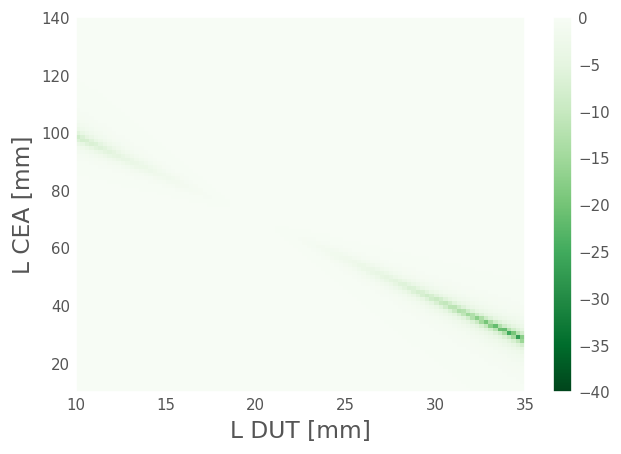

In [27]:
L_DUTs = np.linspace(10e-3, 35e-3, 100)
L_CEAs = np.linspace(10e-3, 140e-3, 100)

LL_DUTs, LL_CEAs = np.meshgrid(L_DUTs, L_CEAs)

@interact(f=(60, 65, 0.1))
def plot_2D(f=62.64):
    S11dB = S11dB_vec(f*1e6, LL_DUTs, LL_CEAs, add_loss=1.0)
    fig,ax=plt.subplots()
    c=ax.pcolor(LL_DUTs*1e3, LL_CEAs*1e3, S11dB, vmin=-40, vmax=0, cmap='Greens_r')
    plt.colorbar(c)
    ax.set_xlabel('L DUT [mm]', fontsize=14)
    ax.set_ylabel('L CEA [mm]', fontsize=14)

## Optimizing from S11 measurements

In [5]:
filename = 'data/RES2.ASC'

exp_freq,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)

exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB = 20*np.log10(exp_mag)
# find the match frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


In [6]:
def optim_fun_impedance(short_properties):
    L_DUT, Z_DUT, L_CEA, Z_CEA, add_loss = short_properties
    # calculates the resonator S11 vs freq
    S11dB = []
    for f in exp_freq:
        _cfg = T.Configuration(f, P_in=1, L_DUT=L_DUT, L_CEA=L_CEA, 
                               Z_short_DUT=Z_DUT, Z_short_CEA=Z_CEA, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    
    crit = np.sum( (np.array(S11dB) - exp_mag_dB)**2) #least square 
    print(short_properties, crit)
    return crit  

In [7]:
d_DUT_0 = 0.035 # m
d_CEA_0 = 0.035 # m
Z_DUT_0 = 0.01 # Ohm
Z_CEA_0 = 0.01 # Ohm
add_loss = 1.0

bounds_pties = ((20e-3, 63e-3), (1e-3, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-3, 1), # d,Z CEA
                (0.1, 2)) # add losses

opt_res = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, add_loss),
                  bounds=bounds_pties)

[ 0.035  0.01   0.035  0.01   1.   ] 9956.68645719
[ 0.03500001  0.01        0.035       0.01        1.        ] 9956.70295757
[ 0.035       0.01000001  0.035       0.01        1.        ] 9956.68444726
[ 0.035       0.01        0.03500001  0.01        1.        ] 9956.68712244
[ 0.035       0.01        0.035       0.01000001  1.        ] 9956.68554714
[ 0.035       0.01        0.035       0.01        1.00000001] 9956.68640812
[ 0.02   1.     0.005  1.     2.   ] 6430.98245699
[ 0.02000001  1.          0.005       1.          2.        ] 6430.98242234
[ 0.02        1.00000001  0.005       1.          2.        ] 6430.9824574
[ 0.02        1.          0.00500001  1.          2.        ] 6430.98244365
[ 0.02        1.          0.005       1.00000001  2.        ] 6430.98245801
[ 0.02        1.          0.005       1.          2.00000001] 6430.98245703
[ 0.02024813  1.          0.00512956  1.          2.        ] 6429.95300604
[ 0.02024814  1.          0.00512956  1.          2.        ] 6

[ 0.03309784  0.0034455   0.03238703  0.00680031  0.95432379]


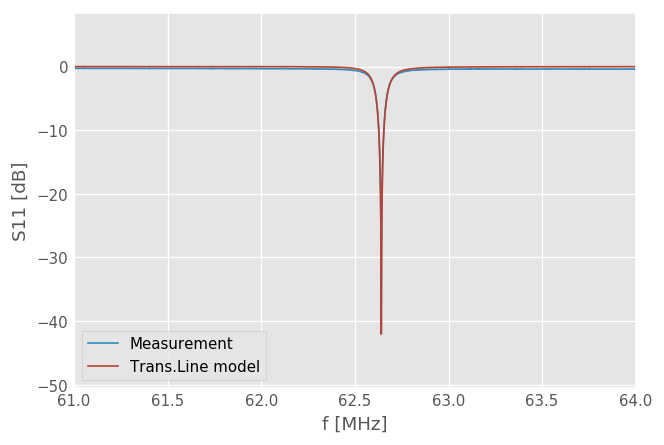

In [28]:
P_in = 20e3 # W

S11dB = []
print(opt_res.x)
L_DUT_opt, Z_DUT_opt, L_CEA_opt, Z_CEA_opt, add_loss_opt = opt_res.x

for f in exp_freq:
    _cfg = T.Configuration(f, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)
    S11dB.append(_cfg.S11dB())

fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB)
ax.plot(exp_freq/1e6, S11dB)
ax.legend(('Measurement', 'Trans.Line model'))
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')

[ 0.03309784  0.0034455   0.03238703  0.00680031  0.95432379]


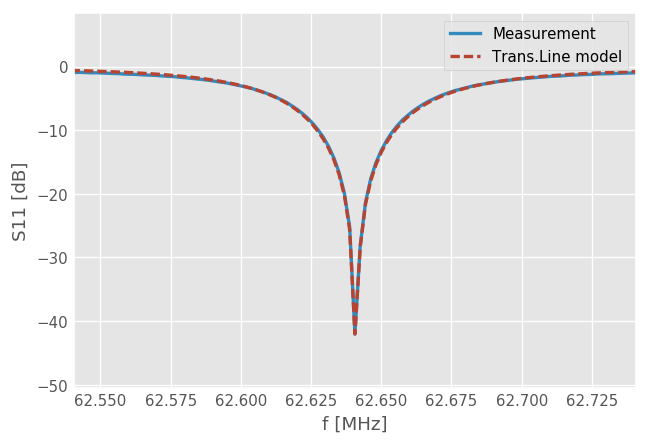

In [29]:
fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.plot(exp_freq/1e6, S11dB, lw=2, ls='--')
ax.legend(('Measurement', 'Trans.Line model'))
ax.set_xlim(exp_freq_match/1e6-0.1, exp_freq_match/1e6+0.1)
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')
print(opt_res.x)

## Voltage and current in the resonator at matching point

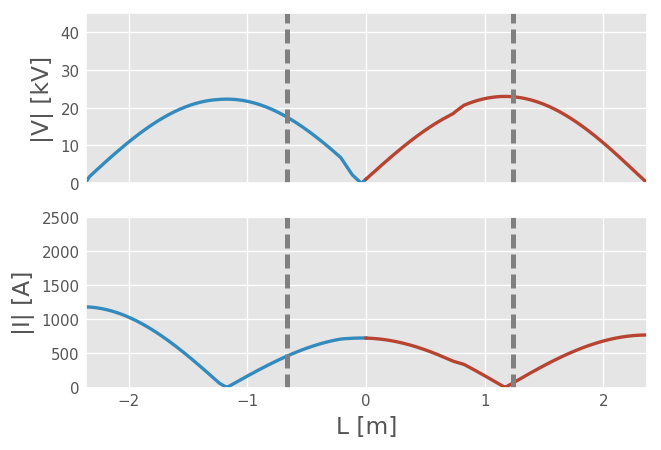

In [30]:
P_in=20e3 # W

cfg_opt = T.Configuration(exp_freq_match, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)

# Calculates the voltage and current along the transmission lines
L_CEA, L_DUT, V_CEA, V_DUT, I_CEA, I_DUT = cfg_opt.voltage_current();

# Plotting V,I
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(-L_DUT, np.abs(V_DUT)/1e3, L_CEA, np.abs(V_CEA)/1e3, lw=2)
ax[0].set_ylim(0, 45)
ax[0].grid(True)
ax[0].set_xlim(min(-L_DUT), max(L_CEA))
ax[0].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[0].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[0].set_ylabel('|V| [kV]', fontsize=14)

ax[1].plot(-L_DUT, np.abs(I_DUT), L_CEA, np.abs(I_CEA), lw=2)
ax[1].set_ylim(0, 2500)
ax[1].grid(True)
ax[1].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[1].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[1].set_xlabel('L [m]', fontsize=14)
ax[1].set_ylabel('|I| [A]', fontsize=14)